# Automatic num_feature selection techniques

In [13]:
from probatus.feature_elimination import ShapRFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

### Basic example of ShapRFECV

In [14]:
# Simple ShapRFECV example
X, y = make_classification(n_samples=500, n_informative=20, n_features=50)
clf = CatBoostClassifier(n_estimators=100, verbose=0)
shap_elimination = ShapRFECV(clf, step=0.2, min_features_to_select=5, cv=5, scoring="f1")
report = shap_elimination.fit_compute(X, y)

In [15]:
# Inspect the report generated by ShapRFECV
# Can you find the best iteration? Look at `train_metric_mean`.
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,50,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[27, 38, 41, 48, 28, 49, 9, 36, 12, 14]",1.000,0.000,0.792,0.029
2,40,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16...","[37, 45, 23, 2, 17, 16, 31, 20]",1.000,0.000,0.834,0.016
3,32,"[0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 18, 1...","[40, 0, 18, 11, 39, 8]",1.000,0.000,0.849,0.011
4,26,"[1, 3, 4, 5, 6, 7, 10, 13, 15, 19, 21, 22, 24,...","[33, 34, 32, 15, 46]",1.000,0.000,0.849,0.026
5,21,"[1, 3, 4, 5, 6, 7, 10, 13, 19, 21, 22, 24, 25,...","[35, 1, 6, 19]",1.000,0.000,0.868,0.026
6,17,"[3, 4, 5, 7, 10, 13, 21, 22, 24, 25, 26, 29, 3...","[7, 42, 5]",0.974,0.001,0.837,0.015
7,14,"[3, 4, 10, 13, 21, 22, 24, 25, 26, 29, 30, 43,...","[43, 4]",0.970,0.006,0.811,0.020
8,12,"[3, 10, 13, 21, 22, 24, 25, 26, 29, 30, 44, 47]","[25, 29]",0.955,0.006,0.797,0.023
9,10,"[3, 10, 13, 21, 22, 24, 26, 30, 44, 47]","[3, 44]",0.942,0.005,0.802,0.021
10,8,"[10, 13, 21, 22, 24, 26, 30, 47]",[26],0.925,0.008,0.783,0.018


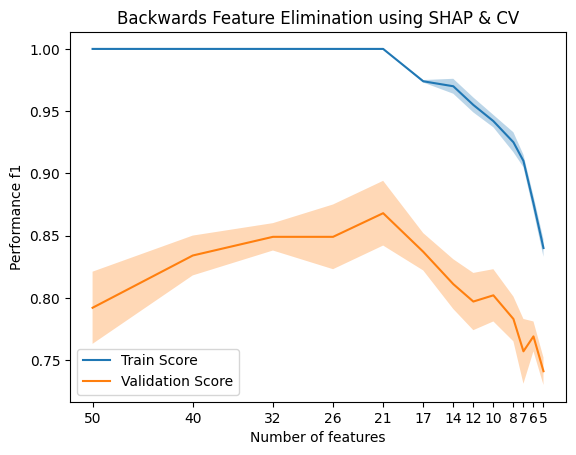

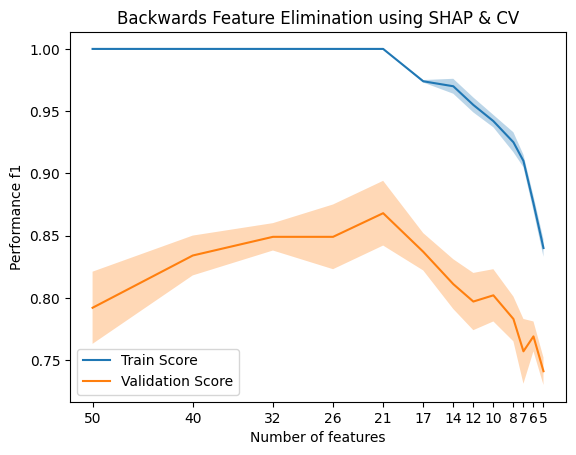

In [16]:
# We can visually inspect the report and try identify the best iteration
shap_elimination.plot()

In [19]:
# Once we have identified which iteration was best, we can get the feature names by:
shap_elimination.get_reduced_features_set(num_features=21)

array([ 1,  3,  4,  5,  6,  7, 10, 13, 19, 21, 22, 24, 25, 26, 29, 30, 35,
       42, 43, 44, 47])

# But, is there a more automated way of selecting "best" features?

Yes, probatus support a few strategies for selecting the best `num_features` for your needs.

Before we jump into these automated techniques, there are a number of factors you might want to consider when selecting the best iteration:
1. **Model performance score:** Most people will care about this the most. You'll try to maximize a score like f1 or accuracy or ROC_AUC. But there are more factors to consider...
2. **Variance of model performance:** If your model performance scores vary considerably across cross validation folds, it might be a sign that your model is not generalizing well. Some people may want to ensure model performance standard deviation is also minimized.
3. **Number of features:** You might want to keep the number of features to a minimum (smaller model, siplier data pipeline, easier to explain model)

To accomodate some of the above needs, probatus supports automated strategies to select the best "num_features". Strategies supported are:
1. **num_features="best":** If what you care about is maximizing `val_metric_mean` (model performance score), this strategy is for you.
2. **num_features="best_coherent":** If you care about high model performance whilst also minimizing variation of model performance between cross validation folds, this strategy is for you.
3. **num_features="best_parsimonious":** If you care about high model performance whilst also minimizing the number of features selected, this model is for you.

In [20]:
# Best
best_features = shap_elimination.get_reduced_features_set(num_features="best")
print(f"The {len(best_features)} best features are: {best_features}")

The 21 best features are: [ 1  3  4  5  6  7 10 13 19 21 22 24 25 26 29 30 35 42 43 44 47]


In [21]:
# Best coherent
best_features = shap_elimination.get_reduced_features_set(num_features="best_coherent")
print(f"The {len(best_features)} best coherent features are: {best_features}")

The 32 best coherent features are: [ 0  1  3  4  5  6  7  8 10 11 13 15 18 19 21 22 24 25 26 29 30 32 33 34
 35 39 40 42 43 44 46 47]


In [22]:
# Best parsimonious
best_features = shap_elimination.get_reduced_features_set(num_features="best_parsimonious")
print(f"The {len(best_features)} best parsimonious features are: {best_features}")

The 21 best parsimonious features are: [ 1  3  4  5  6  7 10 13 19 21 22 24 25 26 29 30 35 42 43 44 47]


In [23]:
# Note, you can change the behavior of `best_coherent` and `best_parsimonious` by changing the `standard_error_threshold` parameter
# Best coherent (standard_error_threshold=0.5)
best_features = shap_elimination.get_reduced_features_set(
    num_features="best_parsimonious", standard_error_threshold=0.5
)
print(f"The {len(best_features)} best coherent features are: {best_features}")

The 21 best coherent features are: [ 1  3  4  5  6  7 10 13 19 21 22 24 25 26 29 30 35 42 43 44 47]


# Support & Ranking
In alignment with the sklearn implementation of RFECV, you can get `support` and `ranking` output from ShapRFECV. 

In [24]:
# Get support (boolean mask of X feature columns)
best_features = shap_elimination.get_reduced_features_set(num_features="best", return_type="feature_names")
best_features_support = shap_elimination.get_reduced_features_set(num_features="best", return_type="support")
best_features_ranking = shap_elimination.get_reduced_features_set(num_features="best", return_type="ranking")
print(f"The {len(best_features)} best features are: {best_features}")
print(f"Support boolean mask: {best_features_support}")
print(f"Ranking: {best_features_ranking}")

The 21 best features are: [ 1  3  4  5  6  7 10 13 19 21 22 24 25 26 29 30 35 42 43 44 47]
Support boolean mask: [False, True, False, True, True, True, True, True, False, False, True, False, False, True, False, False, False, False, False, True, False, True, True, False, True, True, True, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, True, True, True, False, False, True, False, False]
Ranking: [23, 14, 31, 4, 9, 12, 15, 10, 27, 42, 0, 25, 44, 2, 45, 20, 33, 32, 24, 16, 35, 0, 0, 30, 1, 6, 3, 36, 40, 7, 0, 34, 19, 17, 18, 13, 43, 28, 37, 26, 22, 38, 11, 8, 5, 29, 21, 0, 39, 41]
